# Gods Unchained - Exploratory Data Analysis
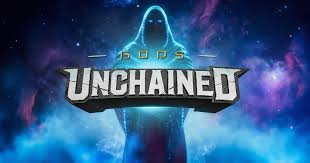


In the competitive world of Gods Unchained, creating an effective deck is crucial to success. A well-balanced deck takes into account **the timing of card distribution**, with some cards ideal for the beginning of the game and others more suitable for the end of the game. Manually classifying each card as “early” or “late” can be time-consuming and subjective.

To address this challenge, we will leverage machine learning to develop a model that can automatically categorize Free God cards based on their attributes (mana cost, attack, health, etc.).

This model will not only help with understanding the right time to launch the card, but will also be made available through an API after the data exploration study.

# Summary
- Libraries Import
- Data Exploration
  - Notebook Configuration
  - Data Loading and First Look
  - Data Cleaning and Preprocessing
  - Analysis
- Feature Engineering
- Model Building
  - Model Selection
  - Model Training
  - Model Evaluation
- Conclusion
- References

## Libraries Import

First, I'll import all the requirement libraries to work with machine learning, image plotting, dataframes and more.

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning and math
import math
from scipy import stats
from scipy.stats import pearsonr, kendalltau, normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# environment and settings
import glob
import os
from os import path
import warnings

## Data Exploration
This section will be dedicated to exploring the data, understanding the features, and preparing the data for the machine learning model.

### Notebook Configuration

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 220

collor_pallet = ['#069FFE', '#00BDE3', '#196CFE', '#FCAC1E', '#F911A4']
sns.set_palette(collor_pallet)
sns.set_style("whitegrid")

_path = os.path.abspath(os.path.dirname(os.path.abspath(os.getcwd())))


### Data Loading and First Look

In [3]:
train_dataframe = pd.read_csv(_path + '/data/train.csv')
test_dataframe = pd.read_csv(_path + '/data/test.csv')

The first step is to load the data and take a look at the first rows to understand the structure of the dataset.

To do it, I'll use the `pandas` library to load the data and the `head()` method to display the first rows.

As an alternative to `pandas` library we could use the `pyspark` library, but in this case the dataset is small and `pandas` is more than enough.

In [4]:
train_dataframe.head()

,id,name,mana,attack,health,type,god,strategy
0,1118,Firewine,5,0,0,spell,nature,early
1,1036,Leyhoard Hatchling,10,2,1,creature,magic,late
2,244,Aetherfuel Alchemist,6,4,4,creature,neutral,late
3,215,Millenium Matryoshka,4,2,2,creature,neutral,late
4,87013,Poison Peddler,4,1,3,creature,neutral,late


In [5]:
train_dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,788.0,18138.823604,36607.267608,1.0,256.5,902.0,1196.25,100920.0
mana,788.0,3.572335,2.190100,0.0,2.0,3.0,5.00,16.0
attack,788.0,2.140863,2.215047,0.0,0.0,2.0,3.00,13.0
health,788.0,2.583756,2.455053,0.0,0.0,2.0,4.00,17.0


In [6]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        788 non-null    int64 
 1   name      788 non-null    object
 2   mana      788 non-null    int64 
 3   attack    788 non-null    int64 
 4   health    788 non-null    int64 
 5   type      788 non-null    object
 6   god       788 non-null    object
 7   strategy  788 non-null    object
dtypes: int64(4), object(4)
memory usage: 49.4+ KB


In [7]:
train_dataframe.dtypes

id           int64
name        object
mana         int64
attack       int64
health       int64
type        object
god         object
strategy    object
dtype: object

In [15]:
for col in train_dataframe.columns:
    if col not in ['id', 'name']:
        print(col, sorted(train_dataframe[col].unique()))
        print("\n")

mana [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16]


attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


health [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17]


type ['creature', 'god power', 'spell', 'weapon']


god ['death', 'deception', 'light', 'magic', 'nature', 'neutral', 'war']


strategy ['early', 'late']




In [9]:
train_dataframe['strategy'].value_counts()

strategy
early    432
late     356
Name: count, dtype: int64

In [10]:
print(f'Dataframe shape: {train_dataframe.shape}')
print(f'Rows size: {train_dataframe.shape[0]}')
print(f'Complete row size: {train_dataframe.dropna().shape[0]}')
print(f'Does the dataset have incomplete values? {train_dataframe.isnull().values.any()}')
print(f'Null values: {train_dataframe.isnull().sum().sum()}')


Dataframe shape: (788, 8)
Rows size: 788
Complete row size: 788
Does the dataset have incomplete values? False
Null values: 0


In the first contact with the dataset, it was possible to have some insights, among which we can mention:
 - The dataset is made up of 788 rows and 8 columns, also considering the response variable `strategy`, which has 432 cards classified as **early** and 356 cards classified as **late**;
 - There is no missing data in the training dataset, so it will not be necessary to carry out any processing in this regard;
 - Althoug the `strategy` column is shown as `object`, it can be considered as a `boolena` type, since it has only two values;

### Data Cleaning and Preprocessing
The next step is to clean the data and prepare it for the machine learning model.

This step is important to ensure that the model can learn from the data and make accurate predictions.